# Notebook for Regression Lesson - Car Price Prediction

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Summary

1. The first step is preparing the data by changing columns name to unified format, checking columns type and convert if necessary.
2. Exploratory Data Analysis to understand the data distribution. We use histograms to understand the distribution of numerical features. We observed a right-skewed distribution for car price (target variable) which could affect the model performance. We tried to normalize the distributioni by using the np.log1p to convert the price to lograithmic format.
3. We also investigate missing value and handle them by filling them with 0 (ignoring the missing feature) or filling them with either statistics such as mean/median/mode.
4. Next step is to set up validation framework. Data is split into train, validation, test portion (60 - 20 - 20).
5. The train data set is now used to train the linear regression. It is a model that approximates the target car price (y) using features of the cars (X). The goal is to find the coefficients or weights of vector w such that Xw = y. To do so, we need to use the Gram Matrix inverse. w will be approximately by (XTX)^-1 * XT * y.
6. After training and obtain the vector w, we calcualte the model using RMSE. This will provide a baseline score for the model.
7. From this step, various techniques are used to further fine tune the model to perform better. Feature engineering is used to add new feature to matrix X derived from information from original data frame. Categorial variables can be One-Hote encoded and used as features.
8. Increasing number of values will evetuanlly affect the model performance, hence regularization is required. Regularization add a small vaalue to the diagonal of the XTX matri, which help stabilize the inverse. We use loop to fine the best regularization value for the model (best RMSE score).
9. Finally, we combined train and validation data to one dataset and train the final model.
10. Make prediction on test data set using the final model.

## 2.1 Data Preparation

Before using any data to start a machine learning model, we need to clean the data and perform an EDA to understand the characteristics of the dataset.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

In [4]:
df.shape

(11914, 16)

In [5]:
# Change the columns name to lower and replace space with underscore
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
# Now for each text column, apply the same logic, lower text and replace space with underscore

text_col = list(df.dtypes[df.dtypes == 'object'].index)

In [7]:
for col in text_col:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [8]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


## 2.2 EDA

In [9]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

make
['bmw' 'audi' 'fiat' 'mercedes-benz' 'chrysler']
48

model
['1_series_m' '1_series' '100' '124_spider' '190-class']
914

year
[2011 2012 2013 1992 1993]
28

engine_fuel_type
['premium_unleaded_(required)' 'regular_unleaded'
 'premium_unleaded_(recommended)' 'flex-fuel_(unleaded/e85)' 'diesel']
10

engine_hp
[335. 300. 230. 320. 172.]
356

engine_cylinders
[ 6.  4.  5.  8. 12.]
9

transmission_type
['manual' 'automatic' 'automated_manual' 'direct_drive' 'unknown']
5

driven_wheels
['rear_wheel_drive' 'front_wheel_drive' 'all_wheel_drive'
 'four_wheel_drive']
4

number_of_doors
[ 2.  4.  3. nan]
3

market_category
['factory_tuner,luxury,high-performance' 'luxury,performance'
 'luxury,high-performance' 'luxury' 'performance']
71

vehicle_size
['compact' 'midsize' 'large']
3

vehicle_style
['coupe' 'convertible' 'sedan' 'wagon' '4dr_hatchback']
16

highway_mpg
[26 28 27 25 24]
59

city_mpg
[19 20 18 17 16]
69

popularity
[3916 3105  819  617 1013]
48

msrp
[46135 40650 36350 29450 345

<Axes: xlabel='msrp', ylabel='Count'>

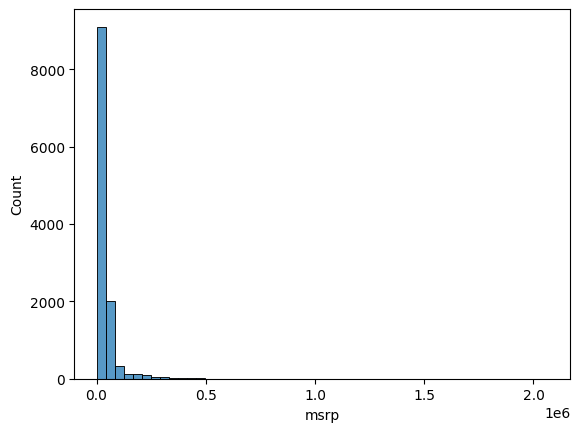

In [10]:
# Distribution of car price
sns.histplot(df.msrp, bins=50)

Car price is not distributed evenly, there is a long tail on the right indicating that there are only a few cars with very high price (up to 2m). The majority of car is priced at below 150k. To see the distribution of the majority, we can zoom in and focus only on the proportion of car priced at below 200k.

<Axes: xlabel='msrp', ylabel='Count'>

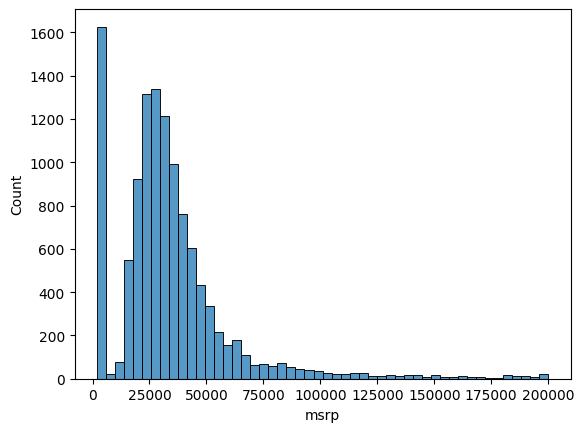

In [11]:
sns.histplot(df.msrp[df.msrp < 200000], bins=50)

The distribution of price is better, but still skewed with a long tail. To converse the distribution to a normal-like, we need to apply log function to price. To do so, use function np.log1p.

In [12]:
price_logs = np.log1p(df.msrp)

<Axes: xlabel='msrp', ylabel='Count'>

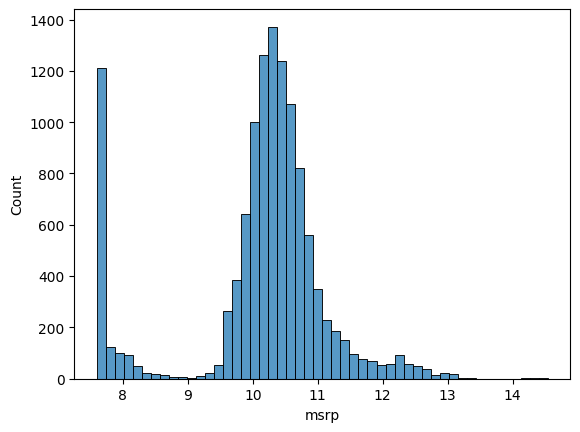

In [13]:
sns.histplot(price_logs, bins=50)

The price distribution becomes more normally distributed with 2 tails and a centre. However, there is still a huge spike of car being priced at 1000. This is the characteristic of the data that need to be taken into account when training model. 

In [14]:
# Missing values

df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

## 2.3 Train, test, validation split

In order to train and evaluate the model, we need to split data into train, test, and validation portion. Train data will be used to train the model and validation set will be used to evaluate the model performance. Finally, the model with best performance will be tested against using the test data set to ensure that it is not lucky that the model has the best performance.

In [15]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [16]:
n_train, n_val, n_test

(7150, 2382, 2382)

To split the data, we first need to shuffle the data in order to get a balanced split for each train, test and validation data set. Then we split the data into the ratio 60 : 20 : 20.

In [17]:
idx = np.arange(n)

In [18]:
np.random.seed(42)
np.random.shuffle(idx)

In [19]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [20]:
df_train.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
3995,gmc,envoy_xl,2005,regular_unleaded,275.0,6.0,automatic,rear_wheel_drive,4.0,NaN,large,4dr_suv,18,13,549,29695
7474,volkswagen,passat,2016,regular_unleaded,170.0,4.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,38,25,873,30495
7300,honda,odyssey,2016,regular_unleaded,248.0,6.0,automatic,front_wheel_drive,4.0,NaN,large,passenger_minivan,28,19,2202,37650
3148,chevrolet,cruze,2015,regular_unleaded,138.0,4.0,manual,front_wheel_drive,4.0,NaN,midsize,sedan,36,25,1385,16170
747,volvo,740,1991,regular_unleaded,162.0,4.0,automatic,rear_wheel_drive,4.0,"luxury,performance",midsize,sedan,20,17,870,2000


In [21]:
# Extract the target from each data set

y_train = np.log1p(df_train.msrp.values)
y_test = np.log1p(df_test.msrp.values)
y_val = np.log1p(df_val.msrp.values)

In [22]:
# Remove the target from data set to prevent data leakage

del df_train['msrp']
del df_test['msrp']
del df_val['msrp']

In [23]:
len(y_train), len(y_val), len(y_test)

(7150, 2382, 2382)

In [24]:
y_train[:5]

array([10.29876764, 10.32535081, 10.53611479,  9.69097479,  7.60140233])

## 2.4 Linear Regression
Linear regression is finding a function g(x) that can approximates y with the lowest error (error to be defined). In this section, we try to define a simply function for one observation.

In [25]:
df_train.iloc[6]

make                                           ford
model                                          flex
year                                           2016
engine_fuel_type     premium_unleaded_(recommended)
engine_hp                                     365.0
engine_cylinders                                6.0
transmission_type                         automatic
driven_wheels                       all_wheel_drive
number_of_doors                                 4.0
market_category                           crossover
vehicle_size                                  large
vehicle_style                                 wagon
highway_mpg                                      21
city_mpg                                         15
popularity                                     5657
Name: 4759, dtype: object

In [26]:
xi = [365, 15, 56] # vector xi of the observation, contain the variables used in our model
w0 = 7.17 # bias or w0
w = [0.01, 0.04, 0.002] # weight for each features of xi

In [27]:
def linear_regression(xi):
    n = len(xi)
    pred = w0
    for j in range(n):
        pred += xi[j] * w[j]

    return pred

In [28]:
linear_regression(xi)

11.532

In [29]:
np.expm1(linear_regression(xi))

np.float64(101924.76161830177)

In the vector form, we can use dot product operation to perform the calculation of the linear regression. Essentially this would replace the need to add xi[j] * w[j] each time. To write it in compact form, include the bias term w0 inside the w matrix. To do so, we need to add a constant of one to X matrix.

Given our model Xtw = y, we need to calculate the matrix w to use as weight for our linear regression. However, X is not always a squared matrix so its inverse is not always defined. Therefore, we need to calculate a GRAM matrix (XtX) which will be a squared matrix, then find the inverse of this matrix. w will be approximated by (XTX)^-1 * XT * y

In [30]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [31]:
X = [
    [148, 24, 1385],
    [132, 25, 2031],
    [453, 11, 86],
    [158, 24, 185],
    [172, 25, 201],
    [413, 11, 86],
    [38,  54, 185],
    [142, 25, 431],
    [453, 31, 86],
]

X = np.array(X)
X
y = [10000, 20000, 15000, 20050, 10000, 20000, 15000, 25000, 12000]

## 2.5 Car price baseline model

We first pick 5 features to used in the linear regression model. For simplicity, we choose the features that are already in numerical format. We will feed this to the training model to obtain the w matrix and use the model to compare against the actual price, see how the model perform.

In [32]:
base_features = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

X_train = df_train[base_features].fillna(0).values

w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)

In [33]:
w0, w

(np.float64(7.9048946245363085),
 array([ 9.35338298e-03, -1.38236607e-01,  1.49631207e-02,  1.51021128e-02,
        -1.97546303e-05]))

<Axes: ylabel='Count'>

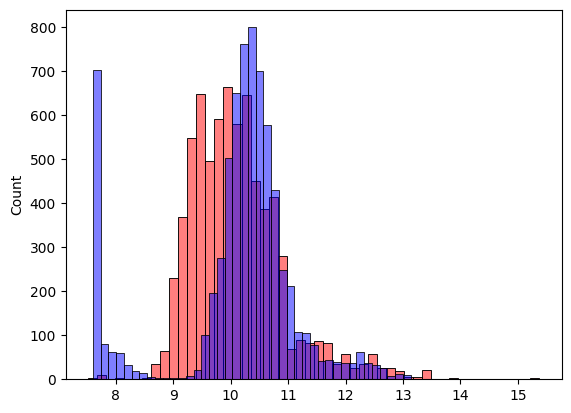

In [34]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

## 2.6 Root Mean Squared Error (MSRE)
This is a metrix to measure the performance of a statistical model. It is calculated by taking the square of difference between the y_pred and y_actual. Calculating the mean of all difference term and then square root.

In [35]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [36]:
rmse(y_train, y_pred)

np.float64(0.7570200472453603)

## 2.7 Validating the model
Apply the linear regression model to validation data set, then calculate the RSME of the result.

In [37]:
def prepare_X(df, base_features=['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']):
    df_num = df[base_features]
    df_num = df_num.fillna(0)
    return df_num.values

In [38]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.739818428511342)

<Axes: ylabel='Count'>

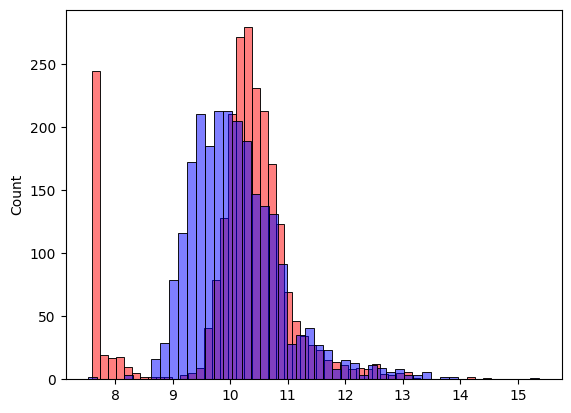

In [39]:
sns.histplot(y_val, color='red', alpha=0.5, bins=50)
sns.histplot(y_pred, color='blue', alpha=0.5, bins=50)

## 2.8 Feature Engineerring

To further improve the model performance, we can create new feature and use it to train our model.
In this example, we calculate the age of each car and feed that into the model.

In [40]:
def prepare_X(df, base_features=['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']):
    df = df.copy()
    df['age'] = 2025 - df['year']
    features = base_features + ['age']
    df_num = df[features]
    df_num = df_num.fillna(0)
    return df_num.values

In [41]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.5133241025826354)

<Axes: ylabel='Count'>

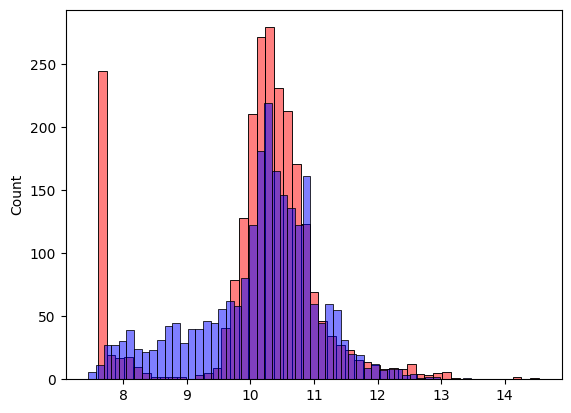

In [42]:
sns.histplot(y_val, color='red', alpha=0.5, bins=50)
sns.histplot(y_pred, color='blue', alpha=0.5, bins=50)

After implementing the new feature, the RMSE improved significantly. We can see that the prediction now more aligned to the actual validation data set.

## 2.9 Categorial Variables

In [43]:
categorical_columns = [
    'make', 'model', 'engine_fuel_type', 'driven_wheels', 'market_category',
    'vehicle_size', 'vehicle_style']

categorical = {}

for c in categorical_columns:
    categorical[c] = list(df_train[c].value_counts().head().index)

In [44]:
categorical

{'make': ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge'],
 'model': ['silverado_1500',
  'tundra',
  'f-150',
  'sierra_1500',
  'beetle_convertible'],
 'engine_fuel_type': ['regular_unleaded',
  'premium_unleaded_(required)',
  'premium_unleaded_(recommended)',
  'flex-fuel_(unleaded/e85)',
  'diesel'],
 'driven_wheels': ['front_wheel_drive',
  'rear_wheel_drive',
  'all_wheel_drive',
  'four_wheel_drive'],
 'market_category': ['crossover',
  'flex_fuel',
  'luxury',
  'luxury,performance',
  'hatchback'],
 'vehicle_size': ['compact', 'midsize', 'large'],
 'vehicle_style': ['sedan',
  '4dr_suv',
  'coupe',
  'convertible',
  '4dr_hatchback']}

In [45]:
def prepare_X(df, base_features=['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']):
    df = df.copy()

    # Feature engineering
    df['age'] = 2025 - df['year']
    features = base_features + ['age']

    # Include categorial feature
    for name, values in categorical.items():
        for value in values:
            df['%s_%s' % (name, value)] = (df[name] == value).astype('int')
            features.append('%s_%s' % (name, value))

    df_num = df[features]
    df_num = df_num.fillna(0)
    
    return df_num.values

In [46]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(60.23921547935616)

<Axes: ylabel='Count'>

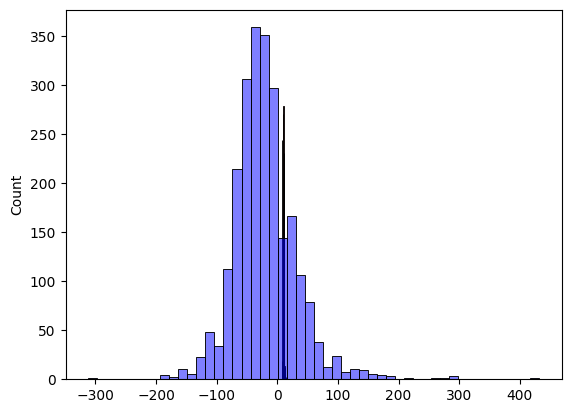

In [47]:
sns.histplot(y_val, color='red', alpha=0.5, bins=50)
sns.histplot(y_pred, color='blue', alpha=0.5, bins=50)

## 2.10 Regularization
If the feature X contain duplicate columns or columns that can be expressed as a linear combination of other columns (i.e. feature are not independent), it will not have an inverse matrix. However, this error could be passed if certain values are different slightly (5 vs 5.00001) between duplicated columns. When this happen, the inverse matrix existed but the component in the matrix will be overstated to very large or very small number. 

Therefore, if we apply the normal equation with this feature matrix, the values assocated with duplicated columns will be inflated, leading to poorer performance of the model. To solve this issue, one possible solution is adding a small number to the diagonal of the feature matrix --> this is called regularization. This will ensure that each columns is linear independant. The regularization value is a hyperparameter of the model (we will need to tune and find the best value for the model).


In [48]:
def train_linear_regression_reg(X, y, r=0.01):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [49]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.46076157725498584)

<Axes: ylabel='Count'>

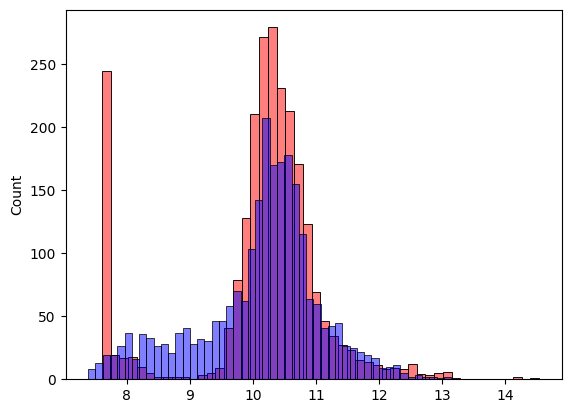

In [50]:
sns.histplot(y_val, color='red', alpha=0.5, bins=50)
sns.histplot(y_pred, color='blue', alpha=0.5, bins=50)

We can observe that the RMSE has improved after regularization is applied.

## 2.11 Model Tuning 
To get the best out of the machine learning model, we can further fine tune the parameter.

In [51]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1.0, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)

    print(r, w0, score)

0.0 5.316272465837904e+16 60.23921547935616
1e-05 6.960736285482073 0.46076045018508777
0.0001 6.960715015655813 0.460760467544598
0.001 6.960547285882775 0.4607605647253587
0.1 6.942201936491315 0.46077472091605265
1.0 6.786428130070396 0.4611681146776688
10 5.817699687084418 0.4746682156371784


At r = 0.0001, the model has the best score so we will use the value as the hyperparameter for the model.

In [52]:
r = 0.0001
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=r)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
score = rmse(y_val, y_pred)
score

np.float64(0.460760467544598)

## 2.12 Using the model for prediction

In [56]:
df_train_full = pd.concat([df_train, df_val]).reset_index(drop=True)

In [58]:
X_train_full = prepare_X(df_train_full)

In [61]:
y_train_full = np.concatenate([y_train, y_val])

In [62]:
w0, w = train_linear_regression_reg(X_train_full, y_train_full, r=0.0001)

In [63]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

np.float64(0.45954603525358684)

The final model performs similar to the train model with similar RMSE score. This means the model generalized well and does not perform well by chance during the training phase. Let's take an example to see how the model perform.

In [66]:
# Select one random car from the test dataframe
car = df_test.iloc[106].to_dict()
car

{'make': 'volkswagen',
 'model': 'golf',
 'year': 2015,
 'engine_fuel_type': 'diesel',
 'engine_hp': 150.0,
 'engine_cylinders': 4.0,
 'transmission_type': 'manual',
 'driven_wheels': 'front_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': 'hatchback,diesel',
 'vehicle_size': 'compact',
 'vehicle_style': '4dr_hatchback',
 'highway_mpg': 45,
 'city_mpg': 30,
 'popularity': 873}

In [71]:
# Create a new df containing the example car
df_small = pd.DataFrame([car])

X_small = prepare_X(df_small)
y_pred = w0 + X_small.dot(w)
y_pred = y_pred[0]

In [74]:
# The predicted price of the car
int(np.expm1(y_pred))

31784

In [75]:
# The actual price of the car
int(np.expm1(y_test[106]))

28395

Predicted car is 31.7k comared to actual price of 28.4k which is 3k off. 